# Failures Prediciton
This jupyter notebook describes how to train an ML model for predicting failures of devices in the factory.

#### Download data
The first step is downloading data. We use here a publicly available dataset. Let's download telemetry, errors and failures csv files.

In [1]:
import os
import urllib.request


REPOSITORY_PATH = "https://github.com/DeeptiChevvuri/Predictive-Maintenance-Modelling-Datasets/raw/master/"
TELEMETRY_FILE_NAME = "telemetry.csv"
FAILURES_FILE_NAME = "failures.csv"
ERRORS_FILE_NAME = "errors.csv"
DATA_FOLDER = "./data"


telemetry_path = os.path.join(DATA_FOLDER, TELEMETRY_FILE_NAME)
failures_path = os.path.join(DATA_FOLDER, FAILURES_FILE_NAME)
errors_path = os.path.join(DATA_FOLDER, ERRORS_FILE_NAME)

os.makedirs(DATA_FOLDER, exist_ok=True)


if not os.path.isfile(telemetry_path):
    urllib.request.urlretrieve(REPOSITORY_PATH + TELEMETRY_FILE_NAME, telemetry_path)
    
if not os.path.isfile(failures_path):
    urllib.request.urlretrieve(REPOSITORY_PATH + FAILURES_FILE_NAME, failures_path)
    
if not os.path.isfile(errors_path):
    urllib.request.urlretrieve(REPOSITORY_PATH + ERRORS_FILE_NAME, errors_path)

#### Read and prepare datasets
Now we are ready to read the datasets into pandas dataframes

In [2]:
import pandas as pd


telemetry_df = pd.read_csv(telemetry_path) 
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'], format='%m/%d/%Y %I:%M:%S %p')
telemetry_df

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259


In [3]:
failures_df = pd.read_csv(failures_path) 
failures_df['datetime'] = pd.to_datetime(failures_df['datetime'], format='%m/%d/%Y %I:%M:%S %p')
failures_df

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
...,...,...,...
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1


In [4]:
errors_df = pd.read_csv(errors_path) 
errors_df['datetime'] = pd.to_datetime(errors_df['datetime'], format='%m/%d/%Y %I:%M:%S %p')
errors_df

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
...,...,...,...
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3


### Exploring data

In real scenarios it's often better to run a separate model for each machine. It might be a separately trained model or just a fine tuned one. In current example scenario we are going to train one model for all machines. However, it's necessary first to ensure that the telemetry values do not differ too much. Box plots are very helpful for checking it.

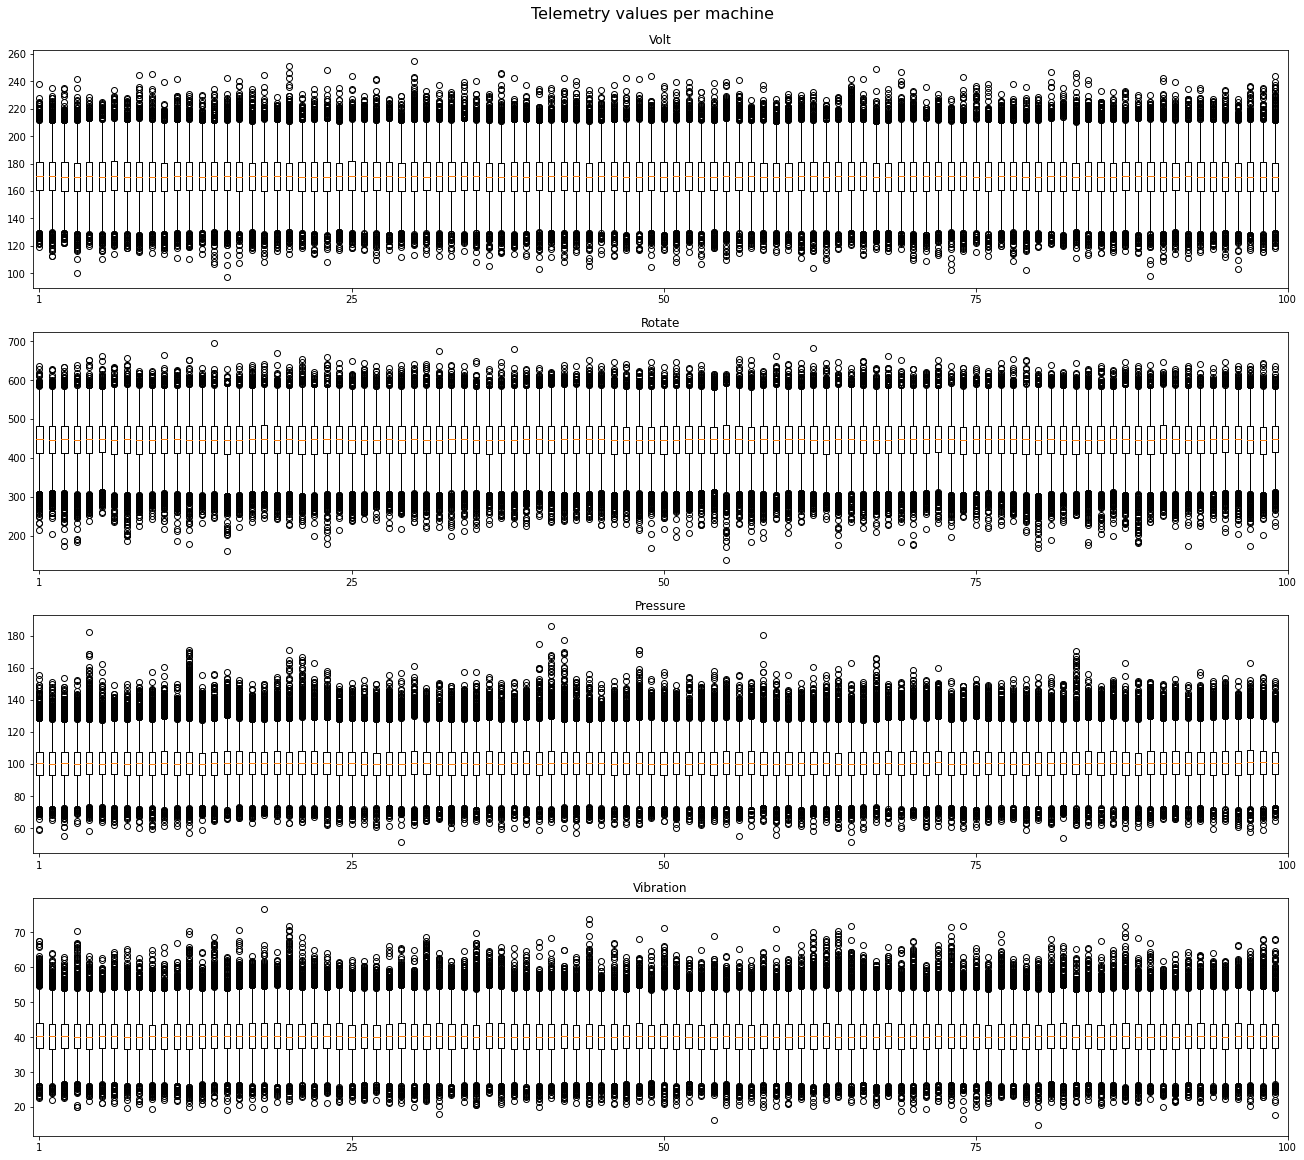

In [5]:
import matplotlib.pyplot as plt
import numpy as np


volt_values = []
rotate_values = []
pressure_values = []
vibration_values = []

for i in range(1,101):
    volt_values.append(telemetry_df[telemetry_df['machineID'] == i]["volt"])
    rotate_values.append(telemetry_df[telemetry_df['machineID'] == i]["rotate"])
    pressure_values.append(telemetry_df[telemetry_df['machineID'] == i]["pressure"])
    vibration_values.append(telemetry_df[telemetry_df['machineID'] == i]["vibration"])

    
fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(18, 16))
fig.suptitle('Telemetry values per machine', fontsize=16)


def build_box_plot(plot_index, plot_values, title):
    axs[plot_index].boxplot(plot_values)
    axs[plot_index].set_title(title)
    axs[plot_index].set_xticks([1, 26, 51, 76, 101])
    axs[plot_index].set_xticklabels([1, 25, 50, 75, 100])

    
build_box_plot(0, volt_values, "Volt")
build_box_plot(1, rotate_values, "Rotate")
build_box_plot(2, pressure_values, "Pressure")
build_box_plot(3, vibration_values, "Vibration")
plt.show()

Looking at the boxplots we can see that most of the telemetry values are not very scattered. So we might assume that machines do not differ too much. We can try training one model for all the devices. 
Now we require to map the errors and failures to the telemetry data frame. 

In [6]:
failures = [False]*len(telemetry_df)
errors = {} 
is_error = [False]*len(telemetry_df)

for error in errors_df.errorID.unique():
    errors[error] = [False]*len(telemetry_df)

for machine_id in telemetry_df.machineID.unique():
    machine_telemetry = telemetry_df[telemetry_df.machineID==machine_id]
    
    for date_time in failures_df[failures_df.machineID == machine_id].datetime:
        for date_time_index in machine_telemetry.index[machine_telemetry.datetime==date_time]:                
            failures[date_time_index] = True
    
    for _, error_row  in errors_df[errors_df.machineID == machine_id].iterrows():
        date_time = error_row.datetime
        error_id = error_row.errorID
        for date_time_index in machine_telemetry.index[machine_telemetry.datetime==date_time]:                
            errors[error_id][date_time_index] = True
            is_error[date_time_index] = True


telemetry_df['failures'] = failures
telemetry_df['is_error'] = is_error

for error_col_key in errors.keys():
    telemetry_df[error_col_key] = errors[error_col_key]
    
print(sum(telemetry_df.failures))
print(sum([sum(telemetry_df[e]) for e in errors.keys()]))

719
3919


In total there are less failures than rows in the failure table. The reason is that this table contains data on component level. Sometimes more than one component fails at the same time. We are more interested in total machine failures, thus ignoring too granular components information.
Now we can look into the telemetry value and compare them with normal. This way we can analyze if there is any straight forward depdendency between telemetry values and failures. To do this, let's build two scatter plots. 

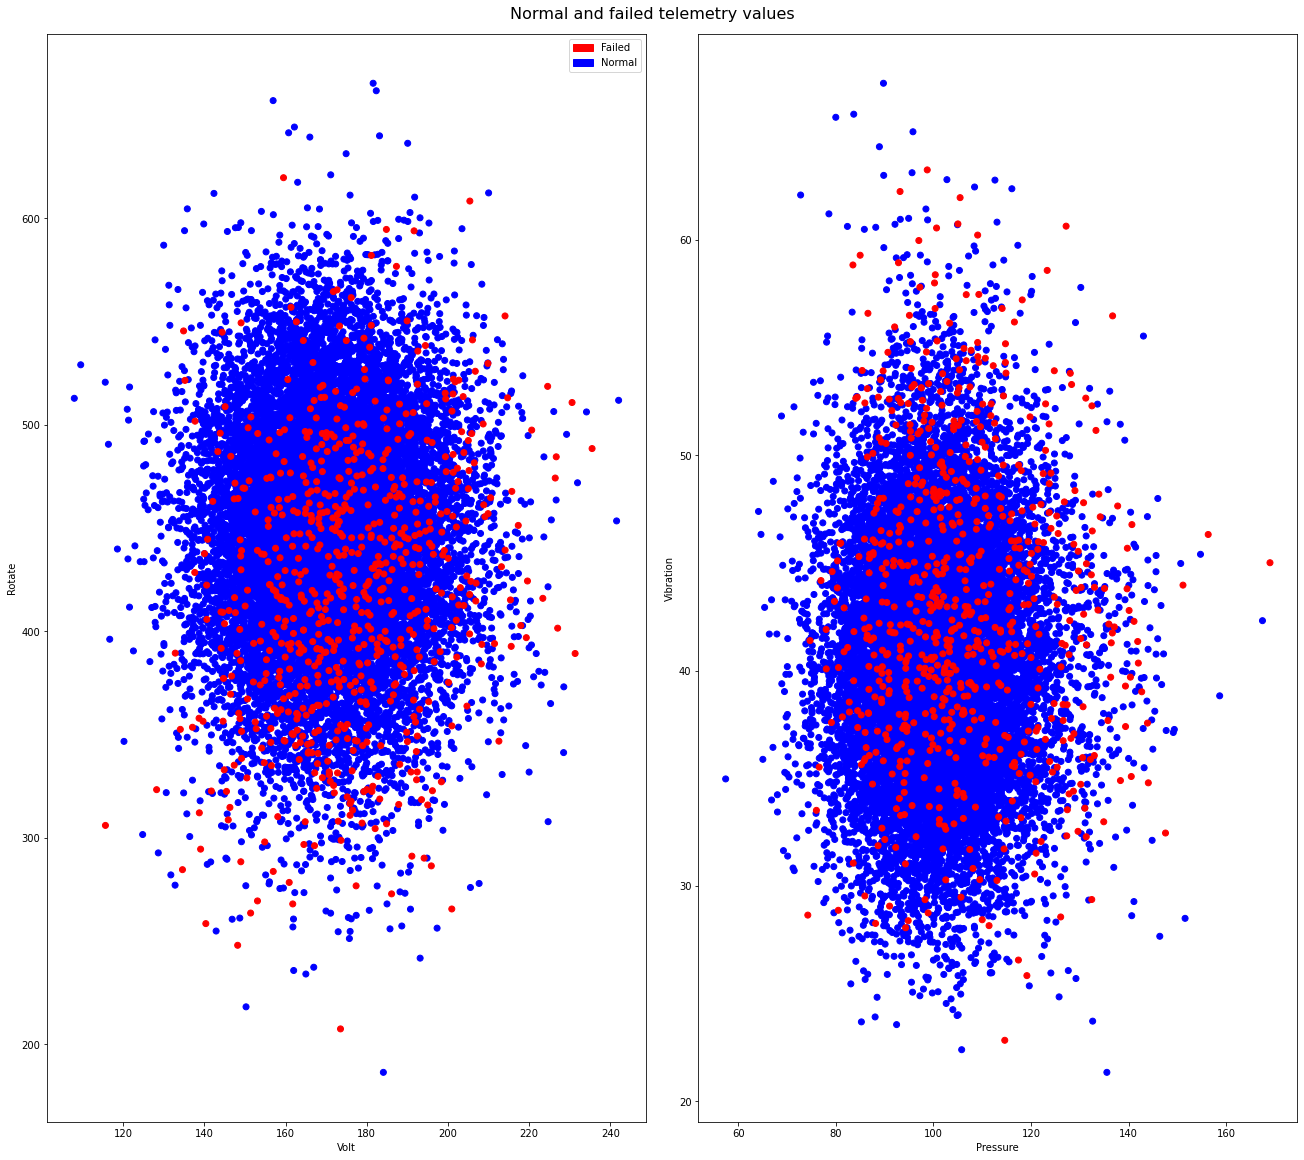

In [7]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


colors = {True: "r", False: "b"}
tel_subsample_df = telemetry_df[telemetry_df.failures==False].sample(frac=0.02)
tel_subsample_df = pd.concat([tel_subsample_df, telemetry_df[telemetry_df.failures==True]])

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(18, 16))
fig.suptitle('Normal and failed telemetry values', fontsize=16)
axs[0].legend(handles=[mpatches.Patch(color='r', label='Failed'), mpatches.Patch(color='b', label='Normal')])
axs[0].set_xlabel('Volt')
axs[0].set_ylabel('Rotate')
axs[0].scatter(tel_subsample_df.volt, tel_subsample_df.rotate, color=tel_subsample_df.failures.map(colors))
axs[1].set_xlabel('Pressure')
axs[1].set_ylabel('Vibration')
axs[1].scatter(tel_subsample_df.pressure, tel_subsample_df.vibration, color=tel_subsample_df.failures.map(colors))
pass

The plots do not show a straight dependency between telemetry and failures. So, we cannot expect from telemetry to be a good failure predictor. It can still however provide useful information in some cases, thus we will keep it. Now let's plot errors that occure before failures.  

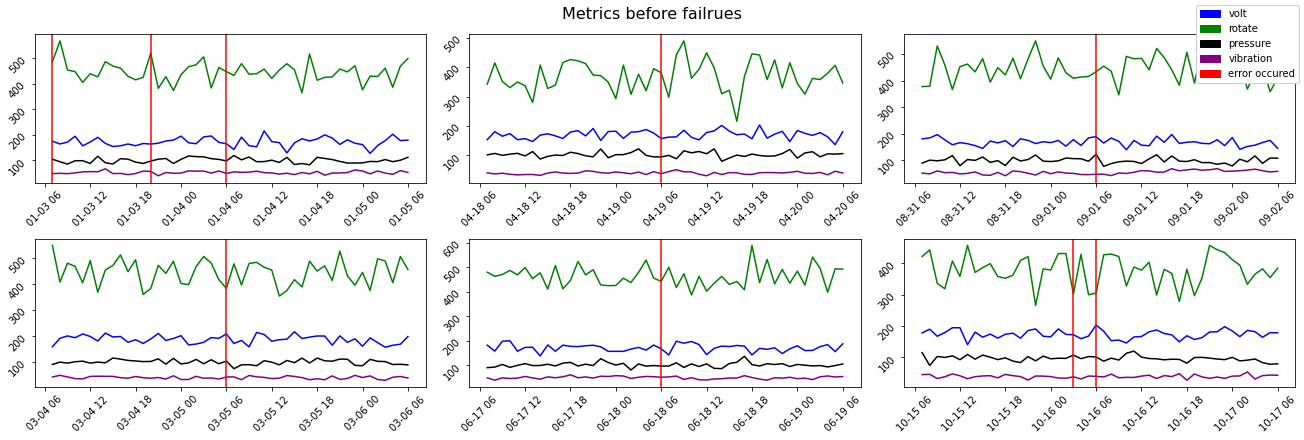

In [8]:
failure_indexes = telemetry_df.index[telemetry_df['failures']]
tel_shift = 48

colors = [mpatches.Patch(color='blue', label='volt'), 
          mpatches.Patch(color='green', label='rotate'), 
          mpatches.Patch(color='black', label='pressure'),           
          mpatches.Patch(color='purple', label='vibration'),
          mpatches.Patch(color='red', label='error occured')]


fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(18, 6))
fig.suptitle('Metrics before failrues', fontsize=16)
fig.legend(handles=colors, facecolor='white', framealpha=1)

def build_plot(row, column, series_df):
    axs[row, column].plot(series_df.datetime, series_df.volt, color='blue')
    axs[row, column].plot(series_df.datetime, series_df.rotate, color='green')
    axs[row, column].plot(series_df.datetime, series_df.pressure, color='black')
    axs[row, column].plot(series_df.datetime, series_df.vibration, color='purple')
    axs[row, column].tick_params(labelrotation=45)

    for _, series_row  in series_df.iterrows():
        if series_row.is_error:
            axs[row, column].axvline(x=series_row.datetime, color='red')


for i in range(6):
    f_index = failure_indexes[i]
    failure_series_df = telemetry_df.iloc[(f_index - tel_shift + 1):(f_index + 1)]    
    row = i % 2
    column = i // 2
    build_plot(row, column, failure_series_df)

The charts above illustrate what is happening with a machine before a failure. Red vertical lines show the moments when errors occure. Charts show that errors tend to occure before the failures and can be a good predictor. The telemetry values are not so obvious and it's hard to find visual patterns in them.
Now we are going to prepare a dataset for model trainig. We pick all 719 failure cases and additionally sample 30000 of non failure ones. We calculate average values for telemetry and for number of errors during a period before the failure. 

### Prepare to training

We consider the following use case: the model tries to predict a potential failure 12 hours before, so a technitian have time to react. The size of the rolling window is 36 hours. Thus, we calculate the averages for the following time frame: 48 hours before - 12 hours before. 

In [9]:
hours_ahead = 12
hours_lag = 36
tel_columns = ["volt", "rotate", "pressure", "vibration"]
error_columns = ["error1", "error2", "error3", "error4", "error5"]

col_names = []
for tel_c in tel_columns:
    col_names.extend([tel_c + "_min", tel_c + "_max", tel_c + "_std", tel_c + "_mean"])

for err_c in error_columns:
    col_names.append(err_c + "_sum")


def get_time_span_statistics(source_df, lag_start, lag_end):
    lag_values_df = source_df.iloc[lag_start:lag_end]
    failure_record = []

    for col_name in tel_columns:
        failure_record.extend([lag_values_df[col_name].min(), 
                               lag_values_df[col_name].max(), 
                               lag_values_df[col_name].std(), 
                               lag_values_df[col_name].mean()])

    for col_name in error_columns:
        failure_record.append(lag_values_df[col_name].sum())
    
    return failure_record


failure_records = []
failure_ranges = []

for f_index in failure_indexes:
    start_i = f_index - hours_ahead - hours_lag
    end_i = f_index - hours_ahead
    
    failure_ranges.extend(np.arange(f_index - hours_ahead - hours_lag, f_index + hours_ahead + hours_lag))
    failure_records.append(get_time_span_statistics(telemetry_df, start_i, end_i))

failure_records_df = pd.DataFrame(failure_records)
failure_records_df.columns = col_names
failure_records_df['is_error'] = True
failure_records_df

,volt_min,volt_max,volt_std,volt_mean,rotate_min,rotate_max,rotate_std,rotate_mean,pressure_min,pressure_max,...,vibration_min,vibration_max,vibration_std,vibration_mean,error1_sum,error2_sum,error3_sum,error4_sum,error5_sum,is_error
0,129.016707,215.656488,16.526837,171.335525,365.213804,568.972310,42.008244,450.361078,82.400818,118.853452,...,39.273567,66.764515,5.277719,51.774580,1,0,1,0,1,True
1,158.476091,216.930340,15.221874,189.627641,354.540120,549.924403,49.173814,444.347733,74.378060,115.764539,...,32.146059,49.029715,4.887823,40.476386,1,0,0,0,0,True
2,146.821322,201.731995,13.785538,171.413036,215.619476,489.502527,54.922459,363.913329,79.552597,121.827141,...,30.093808,50.877634,4.546094,39.263971,0,1,1,0,0,True
3,138.300867,200.092776,15.656864,173.345692,387.342414,581.811206,40.169602,459.948724,80.630055,136.553131,...,38.751573,61.150030,5.433657,49.512631,0,0,0,0,1,True
4,138.740244,207.324122,15.219219,170.153989,345.711420,549.741973,46.975781,444.673658,75.959631,121.728619,...,40.510669,67.409029,6.092420,51.432075,0,0,0,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,145.603331,212.136267,14.325939,170.203287,318.872099,561.052384,51.810797,449.063938,104.241822,154.095588,...,30.749250,54.708004,4.802154,40.358716,0,0,0,1,0,True
715,137.312574,195.589093,13.070156,169.364467,259.096573,488.047354,57.253621,373.551439,80.389208,142.017146,...,39.429014,60.587742,4.804673,49.493438,0,0,0,0,1,True
716,164.312193,224.864627,14.536794,190.509271,379.354036,551.408571,48.437351,453.582009,84.148316,134.365456,...,26.609883,54.567871,5.522002,39.876128,1,0,0,0,0,True
717,163.476447,229.249877,13.718246,193.127389,325.420678,548.251346,48.218963,456.922911,85.577543,118.707002,...,31.921128,53.508080,4.818453,40.791658,1,0,0,0,0,True


In [10]:
normal_functioning_records = []
normal_functioning_indexes = telemetry_df.drop(failure_ranges).sample(30000).index

for n_index in normal_functioning_indexes:        
    start_i = n_index - hours_ahead - hours_lag
    end_i = n_index - hours_ahead
    normal_functioning_records.append(get_time_span_statistics(telemetry_df, start_i, end_i))

normal_functioning_records_df = pd.DataFrame(normal_functioning_records)
normal_functioning_records_df.columns = col_names
normal_functioning_records_df['is_error'] = False
normal_functioning_records_df

,volt_min,volt_max,volt_std,volt_mean,rotate_min,rotate_max,rotate_std,rotate_mean,pressure_min,pressure_max,...,vibration_min,vibration_max,vibration_std,vibration_mean,error1_sum,error2_sum,error3_sum,error4_sum,error5_sum,is_error
0,143.385776,201.507304,14.039069,169.657774,345.877558,544.627212,47.372084,443.978392,78.444557,116.271917,...,30.210533,53.305462,5.685871,39.578280,0,0,0,0,0,False
1,142.928994,189.941691,13.257787,167.581648,350.224319,547.389606,44.433627,448.113456,76.315192,119.259389,...,32.793724,50.440734,4.028990,41.019981,0,0,1,0,0,False
2,137.117664,200.362421,15.213845,168.678838,369.753626,545.974339,44.313425,461.729867,74.297354,119.616506,...,29.612054,51.317095,4.592058,39.698342,0,0,0,0,0,False
3,133.010943,198.674005,14.682785,170.794792,379.599359,535.916106,42.381011,449.216121,83.745123,119.437882,...,28.963315,47.262075,4.781075,38.555273,0,0,0,0,0,False
4,150.909099,198.432192,12.513010,172.956708,256.958141,482.052903,54.057427,365.596292,83.591880,116.973262,...,26.044261,47.553121,4.596065,39.546939,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,138.294179,199.682011,14.906504,170.116996,359.938162,552.988523,47.900325,448.656419,74.373453,121.178567,...,31.469552,45.667603,3.582732,40.180225,0,0,0,0,0,False
29996,138.404599,208.555410,18.185857,171.977498,375.752533,548.232000,39.135379,450.906075,78.774758,111.243470,...,30.121549,47.646423,4.444135,40.033368,0,0,0,0,0,False
29997,136.633701,206.936099,13.609604,167.474461,330.405292,553.006661,50.127959,440.863254,81.091294,118.991894,...,33.901213,51.651652,4.017127,40.507158,0,0,1,0,0,False
29998,149.094472,217.548079,16.413331,180.899822,337.587318,542.394276,44.879680,442.801103,84.616706,117.947738,...,32.126060,52.828075,4.608421,40.414650,0,0,0,0,0,False


Below we combine the failure and non-failure datasets and randomize them.

In [11]:
combined_df = pd.concat([failure_records_df, normal_functioning_records_df], ignore_index=True)
combined_df = combined_df.sample(len(combined_df))
combined_df

,volt_min,volt_max,volt_std,volt_mean,rotate_min,rotate_max,rotate_std,rotate_mean,pressure_min,pressure_max,...,vibration_min,vibration_max,vibration_std,vibration_mean,error1_sum,error2_sum,error3_sum,error4_sum,error5_sum,is_error
15230,152.697085,204.733034,12.082711,172.728264,333.402995,529.985028,41.733996,446.292902,77.065421,118.363351,...,30.792265,50.031658,5.172958,39.903750,0,0,0,0,0,False
13477,141.617890,210.515971,13.971237,173.086920,388.838164,553.555974,37.791531,457.480422,76.979932,114.728424,...,26.200130,55.768080,6.276519,40.358938,0,0,0,0,0,False
15354,124.327141,211.347724,17.787816,171.738214,330.872639,548.250515,47.608029,448.484733,74.798068,118.088019,...,28.998033,48.371529,5.039653,41.037304,0,0,0,0,0,False
7194,136.592869,195.538930,13.532625,168.219185,346.238816,548.005257,51.040830,448.166614,81.535933,124.504155,...,29.954627,47.542787,5.201458,38.621591,0,0,0,0,0,False
24290,145.533311,192.882494,12.499315,169.103647,386.757410,557.215633,46.516391,462.947739,77.333097,117.209714,...,28.282438,50.276904,5.156826,40.136462,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,141.043731,202.024021,17.401075,168.623895,361.386345,585.111841,54.422279,451.634712,85.340715,128.963228,...,29.237043,50.142696,4.980314,40.929622,0,0,0,0,0,False
10130,146.332203,196.467385,13.502112,169.158716,298.036609,536.142095,48.491640,440.763468,81.467294,125.697337,...,30.154262,51.122755,5.100309,40.506133,0,0,0,0,0,False
27866,144.608414,191.123806,12.693902,166.412631,360.313597,494.609643,34.003617,437.317680,107.407224,150.698842,...,31.266468,51.044278,4.473361,40.951217,0,0,0,0,0,False
1048,140.118294,206.372178,14.658136,168.378138,342.845438,576.816225,51.918766,451.988591,78.118606,132.780140,...,30.105948,49.846636,5.082516,39.419035,0,1,0,1,0,False


Finally, we split the dataset into `train`, `test` and `validation`.

In [12]:
split_mask = np.random.rand(len(combined_df)) < 0.7

x_df = combined_df.drop(['is_error'], axis=1)
y_df = combined_df['is_error']

x_train = x_df[split_mask]
y_train = y_df[split_mask]

x_test_validation = x_df[~split_mask]
y_test_validation = y_df[~split_mask]

split_mask = np.random.rand(len(x_test_validation)) < 0.5
x_validation = x_test_validation[split_mask]
y_validation = y_test_validation[split_mask]

x_test = x_test_validation[~split_mask]
y_test = y_test_validation[~split_mask]

print("Number of failure items in training set %d" % sum(y_train))
print("Number of failure items in validation set %d" % sum(y_validation))
print("Number of failure items in test set %d" % sum(y_test))

Number of failure items in training set 486
Number of failure items in validation set 122
Number of failure items in test set 111


### Model Training 

Now we train a gradient boosting model. We know that the dataset is imbalanced so we use AUC PR as a validation metric.

In [13]:
from xgboost import XGBRegressor, XGBClassifier


model = XGBClassifier(max_depth=10, n_estimators=100, seed=0)
model.fit(
    x_train, 
    y_train, 
    eval_set=[(x_validation, y_validation)], 
    early_stopping_rounds=10, 
    eval_metric="aucpr"
)

[0]	validation_0-aucpr:0.94341
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.95205
[2]	validation_0-aucpr:0.95470
[3]	validation_0-aucpr:0.94847
[4]	validation_0-aucpr:0.94798
[5]	validation_0-aucpr:0.91656
[6]	validation_0-aucpr:0.91623
[7]	validation_0-aucpr:0.93456
[8]	validation_0-aucpr:0.95772
[9]	validation_0-aucpr:0.96231
[10]	validation_0-aucpr:0.96177
[11]	validation_0-aucpr:0.96105
[12]	validation_0-aucpr:0.95686
[13]	validation_0-aucpr:0.96054
[14]	validation_0-aucpr:0.96377
[15]	validation_0-aucpr:0.96389
[16]	validation_0-aucpr:0.96506
[17]	validation_0-aucpr:0.96723
[18]	validation_0-aucpr:0.96765
[19]	validation_0-aucpr:0.96826
[20]	validation_0-aucpr:0.96908
[21]	validation_0-aucpr:0.96910
[22]	validation_0-aucpr:0.96933
[23]	validation_0-aucpr:0.96943
[24]	validation_0-aucpr:0.97063
[25]	validation_0-aucpr:0.97022
[26]	validation_0-aucpr:0.97010
[27]	validation_0-aucpr:0.97048
[28]	validation_0-aucpr:0.97159
[29]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

### Evaluation

The model above performs quite good on `validation` dataset. However to get final metrics we need to use a `test set`. All our datasets are imbalanced, so instead of calculating accuracy, we compute **precision**, **recall** and **F1** scores. Additionally, we plot an ROC curve and a confusion matrix.

In [14]:
from sklearn import metrics


test_predictions = model.predict(x_test)
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, test_predictions, average='weighted')

print("Precision {}, Recall {}, F-Score {}".format(precision, recall, fscore))

Precision 0.998325686606688, Recall 0.9983072365636902, F-Score 0.9983146101055798


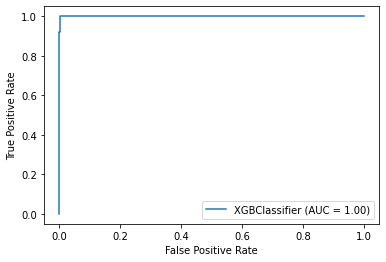

In [15]:
metrics.plot_roc_curve(model, x_test, y_test)

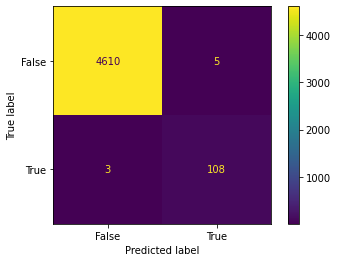

In [16]:
metrics.plot_confusion_matrix(model, x_test, y_test)

The results show that a gradient boosting model performs well. Such model can be deployed in production and used for predicting machine failure cases.